In [14]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
random.seed(43)
import os
from glob import glob
from pathlib import Path
import xmltodict

In [ ]:
def draw_rectangle(ax, top_left_x, top_left_y, width, height, color='red'):
    top_left = (top_left_x, top_left_y)
    bottom_right = (top_left_x + width, top_left_y + height)

    # Plotting each edge of the rectangle on the specified axes
    ax.plot([top_left[0], top_left[0]], [top_left[1], bottom_right[1]], '-', color=color)  # Left edge
    ax.plot([bottom_right[0], bottom_right[0]], [top_left[1], bottom_right[1]], '-', color=color)  # Right edge
    ax.plot([top_left[0], bottom_right[0]], [top_left[1], top_left[1]], '-', color=color)  # Top edge
    ax.plot([top_left[0], bottom_right[0]], [bottom_right[1], bottom_right[1]], '-', color=color)  # Bottom edge

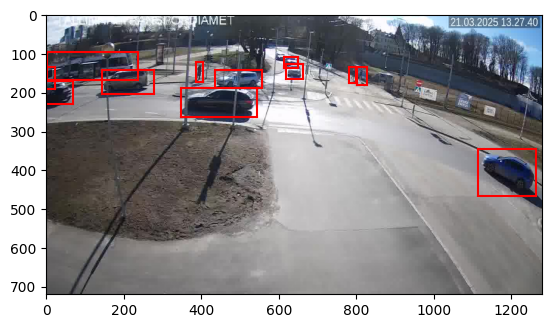

In [ ]:
img_paths = glob("Project/dataset_resized/images/*")
img_path = Path(img_paths[444])

img = cv2.imread(str(img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_path = Path(img_path)
ann_path = f'Project/dataset_resized/Annotations/{img_path.stem}.xml'
if os.path.isfile(ann_path):
    with open(ann_path) as f:
        ann_data = f.read()
img_data = xmltodict.parse(ann_data)['annotation']
H, W = img_data['size']['height'], img_data['size']['width']


fig, ax = plt.subplots()
ax.imshow(img)
for i in range(len(img_data['object'])):
    if isinstance(img_data['object'], list):
        bbox = img_data['object'][i]['bndbox']
    else: 
        bbox = img_data['object']['bndbox']
    top_left_x, top_left_y, width, height = int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']) - int(bbox['xmin']), int(bbox['ymax']) - int(bbox['ymin'])
    
    draw_rectangle(ax, top_left_x, top_left_y, width, height)
plt.show()

In [4]:
import torch
import torch.nn as nn # all the relevant building blocks
import torch.nn.functional as F # functional interfaces for many operations
from torch.utils.data import Dataset, DataLoader # abstract primitives for handling data in pytorch
from torchvision import transforms

if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU instead")
    device = torch.device("cpu")

GPU is available


In [5]:
import torch

def bbox_to_target_offsets(bbox_x, bbox_y, bbox_w, bbox_h, anchor_w, anchor_h, stride, grid_i, grid_j):
    
    # bbox_x = grid_i * stride + sigmoid(t_x) * stride -> sigmoid(t_x) = (bbox_x - gird_i * stride)/stride
    # bbox_y = grid_j * stride + sigmoid(t_y) * stride -> sigmoid(t_y) = (bbox_y - grid_j * stride)/stride
    # bbox_w = anchor_w * exp(t_h) -> exp(t_h) = bbox_w/anchor_w
    # bbox_h = anchor_h * exp(t_w)

    t_x = bbox_x/stride - grid_j
    t_y = bbox_y/stride - grid_i
    t_w = bbox_w/anchor_w
    t_h = bbox_h/anchor_h

    return [t_x, t_y, t_w, t_h]  # We will apply sigmoid and exp to the outputs of the model


def target_offsets_to_bbox(t_x, t_y, t_w, t_h, anchor_w, anchor_h, stride, grid_i, grid_j):
    bbox_x = grid_j * stride + t_x * stride
    bbox_y = grid_i * stride + t_y * stride
    bbox_h = anchor_h * t_h
    bbox_w = anchor_w * t_w
    return [bbox_x, bbox_y, bbox_w, bbox_h] # We will apply sigmoid and exp to the outputs of the model



In [6]:
def iou(anchor_w, anchor_h, bbox_w, bbox_h):

    # Intersection dimensions
    inter_w = min(anchor_w, bbox_w)
    inter_h = min(anchor_h, bbox_h)
    if inter_w <= 0 or inter_h <= 0:
        return 0.0

    inter_area = inter_w * inter_h
    anchor_area = anchor_w * anchor_h
    bbox_area   = bbox_w * bbox_h
    union_area  = anchor_area + bbox_area - inter_area
    return inter_area / union_area

In [7]:

class ObjectDetectionDataset(Dataset):
    def __init__(self, dataset_dir, resize_h, resize_w, anchors, classes,
                 img_ids_to_use = None):
      super(ObjectDetectionDataset, self).__init__()
      self.dataset_dir = dataset_dir
      self.classes = classes 
      self.K = len(classes)
      self.anchors = anchors  # (K, n_anchros, 2)
      self.n_anchors = self.anchors.shape[1]
      self.resize_h = resize_h
      self.resize_w = resize_w

      
      self.stride = None
      self.grid_height = None
      self.grid_width = None
      self.cell_width = None
      self.cell_height = None

      self.images, self.annotations = self.read_dataset()

      if img_ids_to_use is not None: 
        self.images = [img for i, img in enumerate(self.images) if i in img_ids_to_use]
        self.annotations = [ann for i, ann in enumerate(self.annotations) if i in img_ids_to_use]
        
      self.transform = transforms.Compose([
            transforms.Resize((resize_h, resize_w)),
            transforms.ToTensor()
        ])
      

    def set_stride(self, stride):
      self.stride = stride
      assert self.resize_h % stride == 0
      assert self.resize_w % stride == 0
      self.grid_height = int(self.resize_h / stride)
      self.grid_width = int(self.resize_w / stride)

      #self.cell_width = np.ceil(self.resize_w / self.grid_width)
      #self.cell_height = np.ceil(self.resize_h / self.grid_height)

    def read_dataset(self): 
      img_paths = glob(f"{self.dataset_dir}/images/*")
      annt_paths = [f'{self.dataset_dir}/Annotations/{Path(img_path).stem}.xml' for img_path in img_paths]
      annt_datas = []
      for path in annt_paths:
        if not os.path.isfile(path):
           annt_datas.append(None)
           continue
        with open(path) as f:
          annt_data = f.read()
          annt_data = xmltodict.parse(annt_data)['annotation']
          annt_datas.append(annt_data)

      images = [Image.open(file_name) for file_name in img_paths]
      annotations = [self.parse_annotation(annt) for annt in annt_datas]

      return images, annotations


    def parse_annotation(self, annt_data):
      """
      Parse annotations for a single image and
      get image pixel coordinates for bbox center, width and height
      """
      
      if annt_data is None: 
         return []
      
      this_img_annotations = []
      for i in range(len(annt_data['object'])):
        if isinstance(annt_data['object'], list):
            object_data = annt_data['object'][i]
        else: 
            object_data = annt_data['object']
          
        bbox_data = object_data['bndbox']
        cls_name = object_data['name']
        class_id = self.classes.index(cls_name)

        H, W = annt_data['size']['height'], annt_data['size']['width']

        scale_factor_x = self.resize_w/float(W)
        scale_factor_y = self.resize_h/float(H)

        lx = float(bbox_data['xmin']) * scale_factor_x  # converting to scaled image coords
        ly = float(bbox_data['ymin']) * scale_factor_y
        hx = float(bbox_data['xmax']) * scale_factor_x
        hy = float(bbox_data['ymax']) * scale_factor_y
        center_x = ((lx + hx)/2)
        center_y = ((ly + hy)/2)
        height = (hy - ly)
        width = (hx - lx)
        if center_x >= 1280:
           print(center_x)
        annotation = [class_id, np.round(center_x), np.round(center_y),  np.round(width, 2), np.round(height, 2)]
        this_img_annotations.append(annotation)
      return this_img_annotations

    
    def create_targets_tensor(self, annotations, image):
      """
      Turn bbox annotations into learning targets
      param annotations: List of [class_id, x_center, y_center, width, height]
      param image: 
      """

      targets = torch.zeros((self.grid_height, self.grid_width, self.n_anchors, self.K + 5))
      
      for annotation in annotations:
          class_id, bbox_x, bbox_y, bbox_w, bbox_h = annotation
          anchor_ious = []
          width, height = image.size
          # scale_factor_x = self.resize_w/width
          # scale_factor_y = self.resize_h/height
          for n in range(self.n_anchors):
            anchor_h = self.anchors[class_id][n][0] * self.resize_h
            anchor_w = self.anchors[class_id][n][1] * self.resize_w
            this_iou = iou(anchor_w,anchor_h, bbox_h, bbox_w)
            anchor_ious.append(this_iou)
            grid_j = int(bbox_x // self.stride)
            grid_i = int(bbox_y // self.stride)
            target_offsets = bbox_to_target_offsets(bbox_x, bbox_y, bbox_w, bbox_h, 
                                                    anchor_w, anchor_h,
                                                    self.stride, grid_i, grid_j)  # Size (4, )

            if targets[grid_i, grid_j, n, self.K+4] == 1:
              break # if there is already an object in the same grid

            targets[grid_i, grid_j, n, class_id] = 1  # Class score
            targets[grid_i, grid_j, n, self.K:self.K+4] = torch.tensor(target_offsets)

          best_anchor_n = np.argmax(anchor_ious)

          targets[grid_i, grid_j, best_anchor_n, self.K+4] = 1  # High confidence only for the best anchor
               
      return targets.view(self.grid_height, self.grid_width, self.n_anchors, (self.K + 5))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        trans_image = self.transform(image)
        bboxes = self.annotations[idx]
        targets = self.create_targets_tensor(bboxes, image)

        return trans_image, targets

In [8]:
from torchvision.models import get_model
from torch import nn

class AdvancedObjectDetector(nn.Module):
  def __init__(self, K, num_anchors):
    super(AdvancedObjectDetector, self).__init__()
    self.K = K
    self.n_anchors = num_anchors

    self.efficentnet = get_model('efficientnet_b1', weights="IMAGENET1K_V2")
    self.backbone = self.efficentnet.features
    
    backbone_out_channels = self.efficentnet.features[-1][0].out_channels
    self.head = nn.Conv2d(
          in_channels=backbone_out_channels,  
          out_channels=num_anchors*(5 + K),
          kernel_size=1
      )


  def get_stride(self):
    h, w = 640, 640
    x = torch.randn(1, 3, h, w)
    outputs = self.backbone(x)
    f_h = outputs.shape[2]
    f_w = outputs.shape[3]
    stride_y = h/f_h
    stride_x = w/f_w
    assert stride_x == stride_y
    assert int(stride_x) == stride_x
    return int(stride_x)

  def forward(self, x):

    x = self.backbone(x)
    x = self.head(x)

    # Reshape to [B, H, W, n_anchors, K+4+1]
    #print(x.shape) # B, C, H, W
    x = x.view(x.shape[0], self.n_anchors, self.K + 5, x.shape[-2], x.shape[-1]) # B, N, K+5, H, W
    x = x.permute(0, 3, 4, 1, 2).contiguous()  # B, H, W, N, K+5
    # Softmax if we had to use it would have been here:
    # x[..., 0:self.K] = torch.So(x[..., 0:self.K]) # first K are responsible for K classes

    # Apply sigmoid to object center coordinates (assumed to be the next two values after class scores)
    x[..., :, self.K:self.K+2] = torch.sigmoid(x[...,:, self.K:self.K+2])

    # Apply exp to width, height (the next three values)
    x[...,:, self.K+2:self.K+4] = torch.exp(x[...,:, self.K+2:self.K+4])

    # Apply sigmoid to confidence
    x[...,:, self.K+4:self.K+5] = torch.sigmoid(x[...,:, self.K+4:self.K+5])
    
    return x

In [9]:
classification_loss = nn.CrossEntropyLoss() # For classes
bbox_loss = nn.MSELoss()  # For bounding box coordinates and sizes
confidence_loss = nn.BCELoss()  # For object confidence scores

def compute_loss(predictions, targets, K=6, lambda_coord=1, lambda_noobj=0.3, verbal=False):
    
    # Extract predictions
    pred_confidence = predictions[..., K+4]  # Confidence scores

    pred_classes = predictions[..., :K]  # Assuming class scores are the first K channels
    pred_coords = predictions[..., K:K+2]  # Next two channels for coordinates
    pred_sizes = predictions[..., K+2:K+4]  # Sizes (width and height)
    

    
    # Similar extraction needs to be done for targets based on our dataset structure
    # Extract targets
    targets_confidence = targets[..., K+4]
    object_mask = targets_confidence == 1
    targets_classes = targets[..., :K]
    targets_coords = targets[..., K:K+2]
    targets_sizes = targets[..., K+2:K+4]
    
    loss_classes = (classification_loss(pred_classes[object_mask], targets_classes[object_mask])
                    if object_mask.sum() > 0 else 0.0)

    # Compute the localization (bbox coordinate) losses only on positive anchors.
    loss_coords = (bbox_loss(pred_coords[object_mask], targets_coords[object_mask])
                   if object_mask.sum() > 0 else 0.0)
    
    loss_sizes = (bbox_loss(pred_sizes[object_mask], targets_sizes[object_mask])
                  if object_mask.sum() > 0 else 0.0)


    loss_conf_obj = (confidence_loss(pred_confidence[object_mask], 
                                     targets_confidence[object_mask])
                     if object_mask.sum() > 0 else 0.0)
    
    negative_mask = ~object_mask
    loss_conf_noobj = (confidence_loss(pred_confidence[negative_mask], 
                                    targets_confidence[negative_mask])
                    if negative_mask.sum() > 0 else 0.0)
    
    loss_confidence = loss_conf_obj + lambda_noobj * loss_conf_noobj
    #print(targets_classes.shape, pred_classes.shape)

    # loss_classes = classification_loss(pred_classes, targets_classes)
    # loss_coords = bbox_loss(pred_coords, targets_coords)
    # loss_sizes = bbox_loss(pred_sizes, targets_sizes)
    # loss_confidence = confidence_loss(pred_confidence, targets_confidence)

    if verbal:
      print(f'Classes loss: {loss_classes}; Coordinates loss: {loss_coords}; Sizes loss: {loss_sizes}; Confidence loss: {loss_confidence}')

    # Combine losses
    total_loss = loss_coords + lambda_coord * loss_sizes + loss_confidence + loss_classes

    return total_loss

def fit(model, optimizer, loss_func, train_loader, val_loader, n_epochs, verbose=False):
  history = {'loss': [], 'val_loss': []}

  for epoch in range(n_epochs):
    # initialise losses for logging
    epoch_loss, val_epoch_loss = 0.0, 0.0

    model.train()
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()   # reseting gradients

        # Forward pass
        outputs = model(images)

        loss = loss_func(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    model.eval()
    with torch.inference_mode():
      for images, targets in val_loader:
          images, targets = images.to(device), targets.to(device)

          # Forward pass only
          outputs = model(images)
          loss = loss_func(outputs, targets)

          val_epoch_loss += loss.item()

    history['loss'].append(epoch_loss/len(train_loader))
    history['val_loss'].append(val_epoch_loss/len(val_loader))

    print(f"Epoch {epoch + 1}, Loss: {history['loss'][-1]}, Val loss: {history['val_loss'][-1]}")

  return history

In [12]:
classes = ['passenger_car', 'pedestrian', 'bus', 'tram', 'utility_vehicle', 'lorry']
anchors = [] # (K, n_anchros, 2)
for c in classes:
    anchors.append([[0.0526, 0.0301],
                    [0.0935, 0.0653],
                    [0.1572, 0.1149],
                    [0.2518, 0.1901],
                    [0.4014, 0.3450],
                    [0.6490, 0.7201]])  # Anchors relative to image size
anchors = np.array(anchors)
model = AdvancedObjectDetector(len(classes), num_anchors=anchors.shape[1])
stride = model.get_stride()

model_img_width = int(1280/2)
model_img_height =  int(704/2)

train_dataset = ObjectDetectionDataset('Project/dataset_resized_split/train',
                                       model_img_height, model_img_width, anchors=anchors,classes=classes)
val_dataset = ObjectDetectionDataset('Project/dataset_resized_split/val', model_img_height, model_img_width, anchors=anchors,classes=classes)
train_dataset.set_stride(stride)
val_dataset.set_stride(stride)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

In [13]:
obj_detection_model = model.to(device)
obj_detection_model.train()  # Set the model to training mode
optimizer = torch.optim.Adam(obj_detection_model.parameters(), lr=1e-4)
#state_dict = torch.load('Project/checkpoint.pth', map_location=torch.device('cpu'))
#model.load_state_dict(state_dict['model_state_dict'])
history = fit(model, optimizer, compute_loss, train_loader, val_loader, 30) # feel free to change number of epochs
checkpoint = {
    'history': history,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # 'loss': loss,  # If you want to store the last loss value
}

torch.save(checkpoint, 'Project/checkpoint.pth')

Epoch 1, Loss: 4.33826840420564, Val loss: 2.622637987136841
Epoch 2, Loss: 2.482993101080259, Val loss: 2.188114325205485
Epoch 3, Loss: 2.1405325631300607, Val loss: 1.8726861874262493
Epoch 4, Loss: 1.8795361891388893, Val loss: 1.6797162294387817
Epoch 5, Loss: 1.6808085317413013, Val loss: 1.526691327492396
Epoch 6, Loss: 1.531974658370018, Val loss: 1.3964831233024597
Epoch 7, Loss: 1.4136732046802838, Val loss: 1.3303956190745037
Epoch 8, Loss: 1.337168460090955, Val loss: 1.2562711139520009
Epoch 9, Loss: 1.2558478986223538, Val loss: 1.201782653729121
Epoch 10, Loss: 1.192258358001709, Val loss: 1.1575974424680073
Epoch 11, Loss: 1.1367242634296417, Val loss: 1.1148787091175716
Epoch 12, Loss: 1.0819347587724526, Val loss: 1.0863426476716995
Epoch 13, Loss: 1.0415453215440114, Val loss: 1.0605736126502354
Epoch 14, Loss: 1.0114573923250039, Val loss: 1.025264024734497
Epoch 15, Loss: 0.9563707249859968, Val loss: 0.9991673429807028
Epoch 16, Loss: 0.9363038626809915, Val loss:

In [40]:
from itertools import product
bboxes = []
def targets_to_results(targets, anchors, K, H, W): 
    # Targets shape: H, W, n_anchors, K+5
    ijn = product(range(targets.shape[0]), 
                  range(targets.shape[1]))
                  #range(targets.shape[2]))
    results = []
    for i,j in ijn: 
        cell_anchor_preds = targets[i, j]
        anchor_confidences = cell_anchor_preds[:, K+4]
        n = torch.argmax(anchor_confidences)
        
        cell_preds = targets[i, j, n]
        pred_classes = cell_preds[:K] 
        tx, ty, tw, th = cell_preds[K:K+4] 
        pred_confidence = cell_preds[K+4]
        pred_class_id = np.argmax(pred_classes)
        ah, aw = anchors[pred_class_id][n][0]*H, anchors[pred_class_id][n][1]*W

        bbox_coords = target_offsets_to_bbox(tx, ty, tw, th, aw, ah, stride, i, j) # x,y,w,h
        result = (pred_class_id, pred_confidence, *bbox_coords)
        result = [el.numpy() for el in result]
        result[0] = int(result[0])
        
        results.append(result)

    return results

def draw_bbox(ax, bx, by, bw, bh, color='red'):
    top_left_x = bx - bw/2
    top_left_y = by - bh/2

    top_left = (top_left_x, top_left_y)
    bottom_right = (top_left_x + bw, top_left_y + bh)

    # Plotting each edge of the rectangle on the specified axes
    ax.plot([top_left[0], top_left[0]], [top_left[1], bottom_right[1]], '-', color=color)  # Left edge
    ax.plot([bottom_right[0], bottom_right[0]], [top_left[1], bottom_right[1]], '-', color=color)  # Right edge
    ax.plot([top_left[0], bottom_right[0]], [top_left[1], top_left[1]], '-', color=color)  # Top edge
    ax.plot([top_left[0], bottom_right[0]], [bottom_right[1], bottom_right[1]], '-', color=color)  # Bottom edge

def plot_results(results, ax, confidence_thr):
    for result in results:
        pred_class_id, pred_confidence, bx, by, bw, bh = result
        if pred_confidence < confidence_thr:
            continue
        colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green', 'tab:brown', 'tab:purple']
        draw_bbox(ax, bx, by, bw, bh, color=colors[pred_class_id])

        

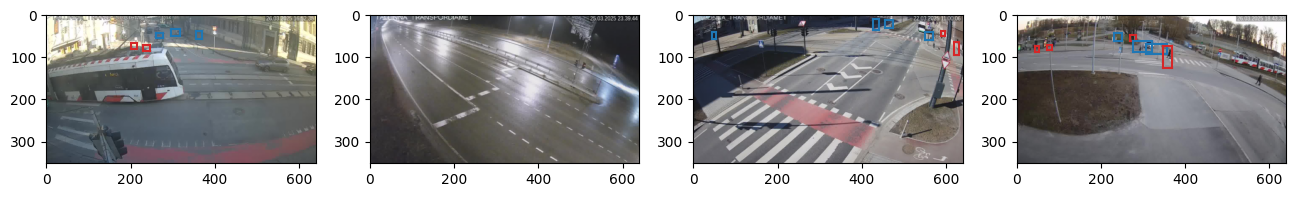

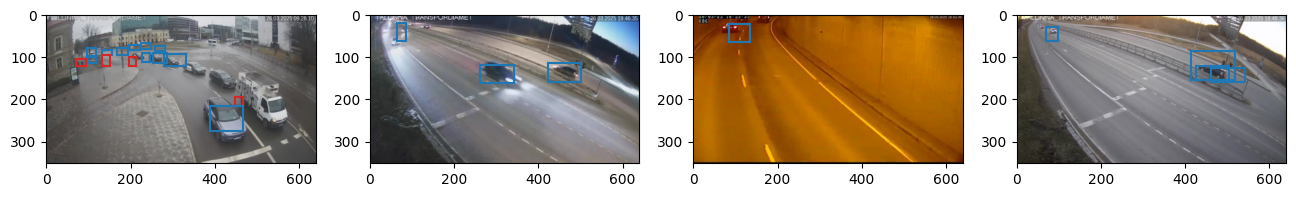

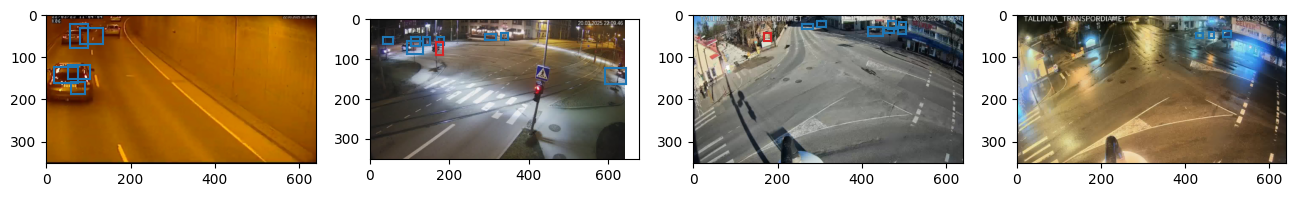

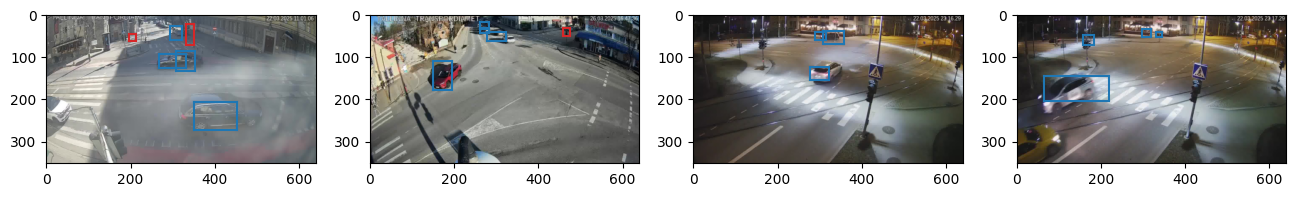

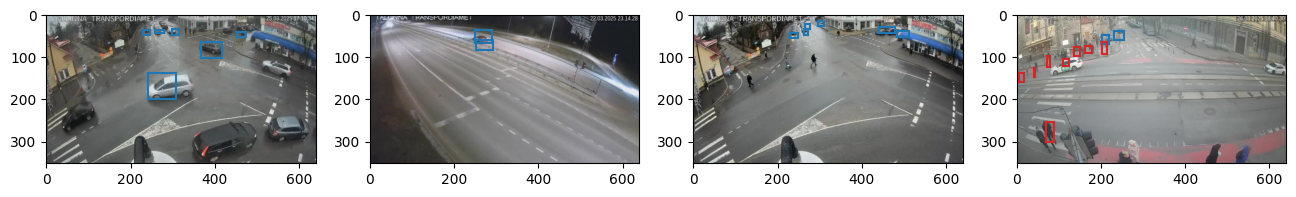

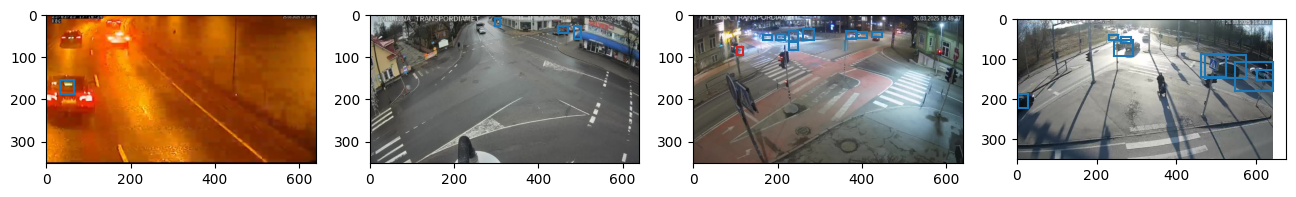

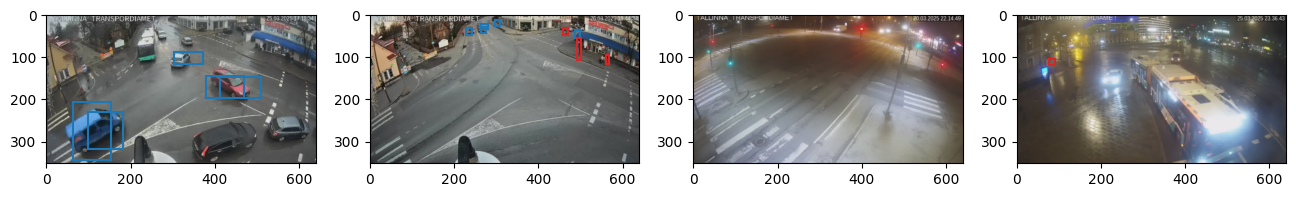

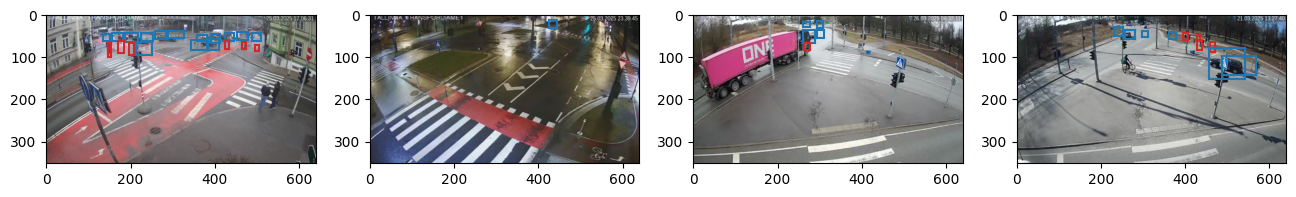

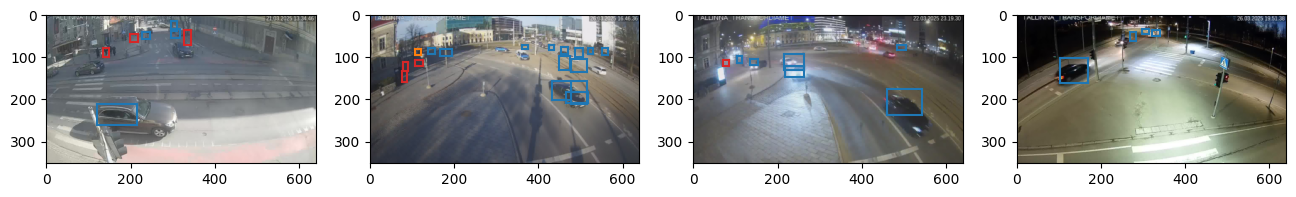

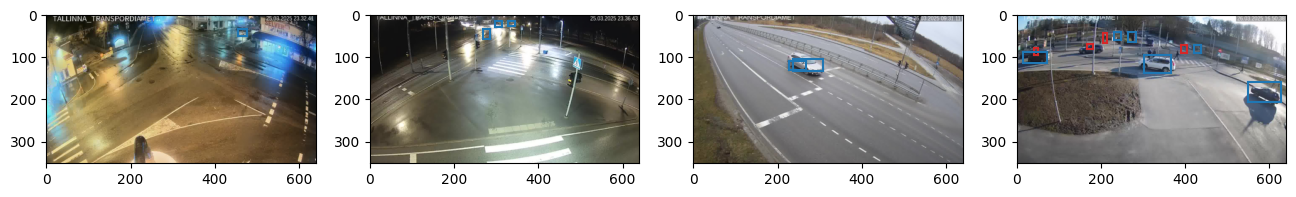

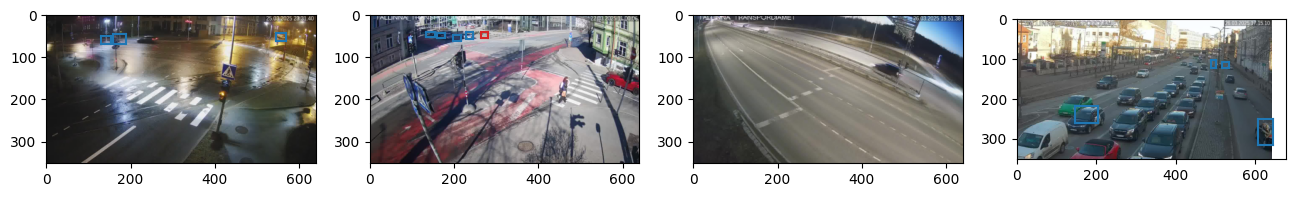

In [41]:
b = 0
model_img_width = int(1280/2)
model_img_height =  int(704/2)
for image_batch, targets_batch in val_loader:
    model.eval
    # only feedforward pass
    val_preds = model(image_batch.to(device))
    val_preds = val_preds.detach().cpu()
    targets_batch = targets_batch.detach().cpu()
    image_batch = image_batch.detach().cpu()
    # save predictions to later be able to work with them|
   # print(anchors)
    fig, axes = plt.subplots(1, 4, figsize=(16, 8))
    for i in range(min(20, 4)): 
        pred = val_preds[i]
        img = image_batch[i]
        ax = axes[i]        
        
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()
        ax.imshow(img)
        results = targets_to_results(pred, anchors, len(classes), H=model_img_height, W=model_img_width)
        plot_results(results, ax, 0.994)
    if b == 10:
        break
    b += 1

In [44]:
import pandas as pd
confidence_thr = 0.99
test_img_paths = glob("Project/test_resized/images/*.jpg")
transform = transforms.Compose([
    transforms.Resize((model_img_height, model_img_width)),
    transforms.ToTensor()
])
model.to(device)
out_data = {'image_id':[], 
            'class_name':[],
            'x_min':[],
            'y_min':[],
            'x_max':[],
            'y_max':[]}
for i in range(len(test_img_paths)):
    path = test_img_paths[i]
    img_id = Path(path).stem
    image = Image.open(path,mode='r') 
    transf_image = transform(image).unsqueeze(0).to(device)
    pred_targets = model.forward(transf_image)
    results = targets_to_results(pred, anchors, len(classes), H=720, W=1280) 
    for result in results: # pred_class_id, confidence, x, y, w, h
        class_id, conf, x, y, w, h = result
        if conf < confidence_thr:
            continue
        class_id = int(class_id)
        out_data['image_id'].append(img_id)
        out_data['class_name'].append(classes[class_id])
        out_data['x_min'].append(x-w/2)
        out_data['y_min'].append(y-h/2)
        out_data['x_max'].append(x+w/2)
        out_data['y_max'].append(y+h/2)
        
df = pd.DataFrame(out_data)
df.to_csv('Project/submission.csv')